In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing # https://scikit-learn.org/stable/modules/preprocessing.html
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score # https://scikit-learn.org/stable/modules/model_evaluation.html

from sklearn.linear_model import LogisticRegression # https://scikit-learn.org/stable/modules/linear_model.html

In [5]:
train_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
test_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test'

features = ["age", "workclass", "fnlwgt", "edu", "edu_num", "ms",
            "occup", "relation", "race", "sex", "cap_gain", "cap_loss",
            "hpw", "country", "target"]

In [6]:
train_data = pd.read_csv(train_url, names=features, sep=r'\s*,\s*', engine='python', na_values="?")
test_data = pd.read_csv(test_url, names=features, sep=r'\s*,\s*', engine='python', na_values="?", skiprows=1)

*Data Cleaning*

**Training Set**

In [7]:
# (a) Fill 'workclass' missing values
workclass_train = train_data['workclass'].mode()[0]
train_data['workclass'].fillna(workclass_train, inplace = True)

# (b) Fill 'occup' missing values
occup_train = train_data['occup'].dropna().value_counts(normalize=True)
np.random.seed(21)

train_data.loc[train_data['occup'].isnull(), 'occup'] = np.random.choice(
    occup_train.index,
    size=train_data['occup'].isnull().sum(),
    p=occup_train.values
)

# (c) Fill 'country' missing values
country_race_train = train_data.groupby('race')['country'].agg(lambda x: pd.Series.mode(x)[0])
train_data['country'] = train_data.apply(
    lambda r: country_race_train[r['race']] if pd.isnull(r['country']) else r['country'],
    axis = 1
)

# (d) Getting rid of redundant variables
train_data.drop('edu_num', axis = 1, inplace = True)
train_data['edu'].replace(['Preschool', '1st-4th', '5th-6th', '7th-8th',
                                 '9th', '10th', '11th', '12th'], 'School', inplace = True)
train_data['race'].replace(['Black', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo', 'Other'],
                   'Other', inplace = True)

# (e) Data Encoding
train_data['target'] = train_data['target'].map({'<=50K': 0, '>50K': 1})

**Testing Set**

In [8]:
# (a) Fill 'workclass' missing values
workclass_test = test_data['workclass'].mode()[0]
test_data['workclass'].fillna(workclass_test, inplace = True)

# (b) Fill 'occup' missing values
occup_test = test_data['occup'].dropna().value_counts(normalize=True)
np.random.seed(21)

test_data.loc[test_data['occup'].isnull(), 'occup'] = np.random.choice(
    occup_test.index,
    size=test_data['occup'].isnull().sum(),
    p=occup_test.values
)

# (c) Fill 'country' missing values
country_race_test = test_data.groupby('race')['country'].agg(lambda x: pd.Series.mode(x)[0])
test_data['country'] = test_data.apply(
    lambda r: country_race_test[r['race']] if pd.isnull(r['country']) else r['country'],
    axis = 1
)

# (d) Getting rid of redundant variables
test_data.drop('edu_num', axis = 1, inplace = True)
test_data['edu'].replace(['Preschool', '1st-4th', '5th-6th', '7th-8th',
                                 '9th', '10th', '11th', '12th'], 'School', inplace = True)
test_data['race'].replace(['Black', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo', 'Other'],
                   'Other', inplace = True)

# (e) Data Encoding
test_data['target'] = test_data['target'].map({'<=50K.': 0, '>50K.': 1})

**Categorical Label Encoding**

In [9]:
# label encoding all categorical columns
from sklearn.preprocessing import LabelEncoder
categorical = ['workclass','edu', 'ms', 'occup', 'relation', 'race', 'sex','country']
label_encoder = LabelEncoder()
for col in categorical:
    label_encoder.fit(train_data[col])
    train_data[col] = label_encoder.transform(train_data[col])
    label_encoder.fit(test_data[col])
    test_data[col] = label_encoder.transform(test_data[col])

In [10]:
# training data
X_train = train_data.drop('target', axis = 1)
y_train = train_data['target']

# test data
X_test = test_data.drop('target', axis = 1)
y_test = test_data['target']

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

***Model using Logistic Regresison***

In [ ]:
from sklearn.metrics import accuracy_score

logistic = LogisticRegression()
logistic.fit(X_train, y_train)

y_pred = logistic.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(acc)

0.8048031447699773


***Using GridSeachCV for Hyperparameter Tuning and Cross Validation to find the Hyper-Parameter:***

In [ ]:
from sklearn.model_selection import GridSearchCV

lambda_vals = [0.01, 0.1, 1, 10, 100]
grid = {
    'C': lambda_vals,
    'penalty': ['l2']
}

grid_search = GridSearchCV(estimator = logistic, param_grid = grid, cv = 5, scoring = 'accuracy')
best_model = grid_search.fit(X_train, y_train)

print(best_model.best_params_)
print(best_model.best_score_)
print(accuracy_score(y_test, best_model.predict(X_test)))

{'C': 0.1, 'penalty': 'l2'}
0.8042136102016342
0.8043117744610282


In [ ]:
#we can also do the same by using cross_val_score
from sklearn.model_selection import cross_val_score

scores = cross_val_score(logistic, X_train, y_train, cv=5)
print("Cross-validation scores:", scores)
print("Average cross-validation score:", scores.mean())

scores_dict = {}
for l in lambda_vals:
  logistic = LogisticRegression(C=l, penalty = 'l2', max_iter=10000)
  scores = cross_val_score(logistic, X_train, y_train, cv = 5, scoring = 'accuracy')
  scores_dict[l] = scores.mean()
best_c = max(scores_dict, key = scores_dict.get)
print(best_c)
print(scores_dict[best_c])

Cross-validation scores: [0.80485183 0.79929361 0.80804668 0.80128993 0.80681818]
Average cross-validation score: 0.8040600475480714
0.1
0.8042136102016342


In [ ]:
# access the performance of each model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

predictions = best_model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

Accuracy: 0.8043117744610282, Precision: 0.6801310043668122, Recall: 0.32397295891835676, F1 Score: 0.4388869320183163


In [ ]:
accuracies = []
precisions = []
recalls = []
f1_scores = []

# Repeat the experiment 3 times
for i in range(3):
    model = LogisticRegression(penalty='l2')
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    accuracies.append(accuracy_score(y_test, preds))
    precisions.append(precision_score(y_test, preds))
    recalls.append(recall_score(y_test, preds))
    f1_scores.append(f1_score(y_test, preds))

print(f"Average Accuracy: {np.mean(accuracies)}, Std: {np.std(accuracies)}")
print(f"Average Precision: {np.mean(precisions)}, Std: {np.std(precisions)}")
print(f"Average Recall: {np.mean(recalls)}, Std: {np.std(recalls)}")
print(f"Average F1 Score: {np.mean(f1_scores)}, Std: {np.std(f1_scores)}")

Average Accuracy: 0.8048031447699774, Std: 1.1102230246251565e-16
Average Precision: 0.6817192600652883, Std: 1.1102230246251565e-16
Average Recall: 0.32579303172126883, Std: 0.0
Average F1 Score: 0.44088669950738907, Std: 0.0


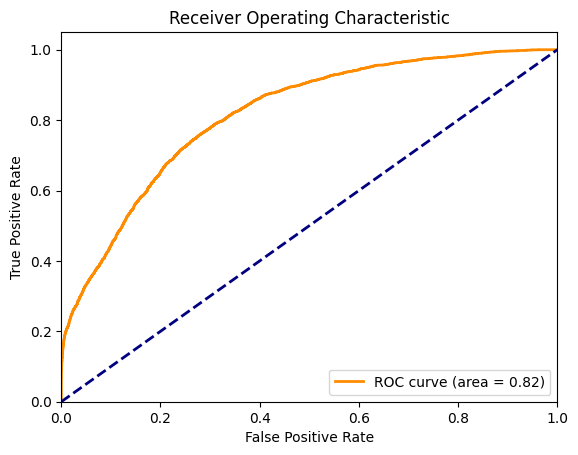

In [ ]:
# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, best_model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

***Takeaways:***


*   The standard deviation values indicates that the model performance is stable across multiple different runs of the experiment (good sign)
*   Precision, Recall Values and the F1 Score averages suggest that the model is decent at predicting the majoarity class, yet it struggles with correctly identifying the positive class, which is a common challege in imbalanced datasets or when model's decision boundaries are not well aligned with the class separation
*   the ROC curve and AUC are suggests that the model is doing a good job at classification tasks, but the final decision on its usability should also consider the context and cost/benefit analysis of the problem at hand



In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, roc_auc_score

# Initialize the Naive Bayes classifier
nb_classifier = GaussianNB()

# Fit the classifier to the training data
nb_classifier.fit(X_train, y_train)

# Predict on the test data
nb_predictions = nb_classifier.predict(X_test)

# Evaluate the classifier
nb_accuracy = accuracy_score(y_test, nb_predictions)
nb_precision = precision_score(y_test, nb_predictions)
nb_recall = recall_score(y_test, nb_predictions)
nb_f1 = f1_score(y_test, nb_predictions)
nb_auc = roc_auc_score(y_test, nb_classifier.predict_proba(X_test)[:, 1])

print(f"Naive Bayes - Accuracy: {nb_accuracy}, Precision: {nb_precision}, Recall: {nb_recall}, F1 Score: {nb_f1}, AUC: {nb_auc}")


Naive Bayes - Accuracy: 0.7992752287943001, Precision: 0.6625421822272216, Recall: 0.30629225169006763, F1 Score: 0.41891891891891897, AUC: 0.8349378390093384


It gives a similar result as the the logistic regression. It seems like there could potentially be a problem that occurred in the data cleaning steps:

Things to re-consider:
*   Reconsider Dropping `edu_num`
*   Handle missing values more strategically
*   Combine categories thoughtfully in categorical variables
*   Feature

In [13]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize the k-NN classifier
# Start with k=5 which is a common default choice
knn_classifier = KNeighborsClassifier(n_neighbors=5)

# Fit the classifier to the training data
knn_classifier.fit(X_train, y_train)

# Predict on the test data
knn_predictions = knn_classifier.predict(X_test)

# Evaluate the classifier
knn_accuracy = accuracy_score(y_test, knn_predictions)
print(f"k-NN - Accuracy: {knn_accuracy}")

k-NN - Accuracy: 0.8218168417173393


In [15]:
from sklearn.model_selection import GridSearchCV
# Define the parameter grid for hyperparameter tuning
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 10],  # The number of neighbors to consider
    'weights': ['uniform', 'distance'],  # Weighting function for prediction
    'metric': ['minkowski'],  # The distance metric to use for the tree
}

grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, scoring='accuracy')
grid_search_knn.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters for k-NN:", grid_search_knn.best_params_)
print("Best cross-validation accuracy for k-NN:", grid_search_knn.best_score_)

# Evaluate on test data using the best parameters
best_knn = grid_search_knn.best_estimator_
best_knn_predictions = best_knn.predict(X_test)
best_knn_accuracy = accuracy_score(y_test, best_knn_predictions)
print(f"Test accuracy with best k-NN: {best_knn_accuracy}")


Best parameters for k-NN: {'metric': 'minkowski', 'n_neighbors': 10, 'weights': 'distance'}
Best cross-validation accuracy for k-NN: 0.8268175329552575
Test accuracy with best k-NN: 0.8267919660954487


After trying the kNN model, we can tell this model fits better than the other two - Naive Bayes and Logistic Regression.